<a href="https://colab.research.google.com/github/CA683-Group99/Wind-Energy-Prediction/blob/main/SharedIslandElectricityRandomForestModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import io
import requests


from plotly.offline import iplot
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from datetime import tzinfo, timedelta, datetime, date

# Any results you write to the current directory are saved as output.

import plotly.express as px
import seaborn as sns

# System Demand and Generation: Actual and Prediction

### Data description
* **System Demand** - represents the predicted electricity production required to meet national consumption.

* **date** - 
* **REGION** - All / Ireland / Nrthern Ireland
* **ActualDemandMW** - Unit MW
* **ForecastDemandMW** - 
* **ForecastWindMW** - 
* **ActualWindMW** - 
* **ActualGenerationMW** - 
* **hour** - 
* **isweekday** - 
* **month** - 
  
Actual and forecast System Demand are shown in **15 minute intervals.**

The data came from EirGrid Group about all island power systems and has been prepared by us for further analysis.

Source: https://smartgriddashboard.eirgrid.com/#all/demand

# Weather Data
 Weather data from weather stations: Belmullet (suffix _BEL), Dublin Airport (_DUB), Shannon Airport (No suffix) and Cork Airport (suffix _COR)

For each station, for example Cork Airport, please see the on https://data.gov.ie/dataset/cork-airport-hourly-data :

Hourly Elements:

| ID | ELEMENT | Unit |
| --- | --- | --- |       
|rain|Precipitation Amount|mm|
|**temp**|Air Temperature|°C|
| wetb|	Wet Bulb Air Temperature|  °C|
|dewpt| Dew Point Air Temperature|	°C	|	
|vappr|	Vapour Pressure	|		hpa|
|rhum	|	Relative Humidity	|	%|
|msl	|	Mean Sea Level Pressure				|		hPa|
|**wdsp**	|	Mean Hourly Wind Speed		|		kt|
|wddir|	Predominant Hourly wind Direction	|	kt|
|ww		Synop Code Present Weather - decode below
|w		Synop Code Past Weather - decode below
|sun		Sunshine duration						hours
|vis		Visibility							m
|clht		Cloud Ceiling Height - if none value is 999			100s feet
|clamt		Cloud Amount							okta

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import os
os.chdir('/content/drive/MyDrive/CA683Project')


In [44]:
  fileP = 'IslandElectricity2017_2020.csv'
  newdf = pd.read_csv(fileP, parse_dates=[1])

In [45]:
#Krystian: Looking for maximal extreme values
print('-----------DATA SIZE -------------')
print(newdf.shape)           # 10 Columns, 35044 rows
count_row = newdf.shape[0]   # 10 Columns
count_col = newdf.shape[1]   # 35044 rows
print('Rows: ', count_row, ', Columns: ', count_col)

print('-----------DATA INFO -------------')
print(newdf.info())

print('-----------DATA MAX Values -------------')
newdf.max()

print('-----------DATA COLUMNS-------------')
columns = newdf.columns.values.tolist()
print (columns)

print('-----------BASIC STATISTICS-------------')
newdf.describe()

-----------DATA SIZE -------------
(35083, 96)
Rows:  35083 , Columns:  96
-----------DATA INFO -------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35083 entries, 0 to 35082
Data columns (total 96 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          35083 non-null  int64         
 1   date                35083 non-null  datetime64[ns]
 2   ind_BEL             35083 non-null  int64         
 3   rain_BEL            35083 non-null  float64       
 4   ind.1_BEL           35083 non-null  int64         
 5   temp_BEL            35083 non-null  float64       
 6   ind.2_BEL           35083 non-null  int64         
 7   wetb_BEL            35083 non-null  float64       
 8   dewpt_BEL           35083 non-null  float64       
 9   vappr_BEL           35083 non-null  float64       
 10  rhum_BEL            35083 non-null  int64         
 11  msl_BEL             35083 non-null  float64     

Unnamed: 0  ind_BEL  ...         month         year
count  35083.000000  35083.0  ...  35044.000000  35044.00000
mean   17541.000000      0.0  ...      6.526424   2018.50000
std    10127.734084      0.0  ...      3.447903      1.11805
min        0.000000      0.0  ...      1.000000   2017.00000
25%     8770.500000      0.0  ...      4.000000   2017.75000
50%    17541.000000      0.0  ...      7.000000   2018.50000
75%    26311.500000      0.0  ...     10.000000   2019.25000
max    35082.000000      0.0  ...     12.000000   2020.00000

[8 rows x 84 columns]

In [46]:
import plotly.express as px

fig = px.scatter(newdf, x='date', y='ActualDemandMW')
fig.show()

Will need to tidy up null values properly!

In [47]:
newdf = newdf.loc[newdf['month'].isnull() == False].copy()

In [48]:
fig = px.scatter(newdf, x='hour', y='ActualDemandMW', facet_col='month', color='isweekday')
fig.show()

In [49]:
fig = px.scatter(newdf, x='hour', y='ActualDemandMW', facet_col='year', color='isweekday')
fig.show()

In [50]:
newdf['WindGenPercent'] = (newdf['ActualWindMW'] / newdf['ActualGenerationMW']) * 100
fig = px.scatter(newdf, x='hour', y='WindGenPercent', facet_col='year')
fig.show()

# Prep smaller dataset to run model

In [51]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35044 entries, 0 to 35067
Data columns (total 97 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Unnamed: 0          35044 non-null  int64         
 1   date                35044 non-null  datetime64[ns]
 2   ind_BEL             35044 non-null  int64         
 3   rain_BEL            35044 non-null  float64       
 4   ind.1_BEL           35044 non-null  int64         
 5   temp_BEL            35044 non-null  float64       
 6   ind.2_BEL           35044 non-null  int64         
 7   wetb_BEL            35044 non-null  float64       
 8   dewpt_BEL           35044 non-null  float64       
 9   vappr_BEL           35044 non-null  float64       
 10  rhum_BEL            35044 non-null  int64         
 11  msl_BEL             35044 non-null  float64       
 12  ind.3_BEL           35044 non-null  int64         
 13  wdsp_BEL            35044 non-null  int64     

In [52]:
redds = newdf.loc[:, ['date', 'hour', 'isweekday', 'month', 'year',
                      'wdsp_BEL', 'wddir_BEL', 'temp_BEL',
                      'wdsp', 'wddir', 'temp',
                      'wdsp_COR', 'wddir_COR',  'temp_COR',
                      'wdsp_DUB', 'wddir_DUB',  'temp_DUB',
                      'ActualWindMW']]

In [53]:
redds[redds.ActualWindMW.isnull() == True]

date  hour isweekday  ...  wddir_DUB  temp_DUB  ActualWindMW
2017  2017-03-26 01:00:00   1.0     False  ...         40       3.2           NaN
4153  2017-06-23 01:00:00   1.0      True  ...        230      14.0           NaN
4154  2017-06-23 02:00:00   2.0      True  ...        220      14.1           NaN
4155  2017-06-23 03:00:00   3.0      True  ...        230      14.0           NaN
4156  2017-06-23 04:00:00   4.0      True  ...        230      14.2           NaN
4157  2017-06-23 05:00:00   5.0      True  ...        230      13.7           NaN
4158  2017-06-23 06:00:00   6.0      True  ...        230      13.9           NaN
4159  2017-06-23 07:00:00   7.0      True  ...        230      14.5           NaN
4160  2017-06-23 08:00:00   8.0      True  ...        230      15.3           NaN
4161  2017-06-23 09:00:00   9.0      True  ...        230      15.7           NaN
4162  2017-06-23 10:00:00  10.0      True  ...        230      16.3           NaN
4163  2017-06-23 11:00:00  11.0      True  ...        240      16.8           NaN
4164  2017-06-23 12:00:00  12.0      True  ...        240      18.2           NaN
10754 2018-03-25 01:00:00   1.0     False  ...        260       4.4           NaN
19659 2019-03-31 01:00:00   1.0     False  ...        330       0.2           NaN
21277 2019-06-06 11:00:00  11.0      True  ...        230      11.4           NaN
28396 2020-03-29 01:00:00   1.0     False  ...         60       3.8           NaN
34495 2020-12-08 03:00:00   3.0      True  ...        260       0.5           NaN

[18 rows x 18 columns]

In [54]:
redds = redds.loc[redds['date'] >= "2020-01-01 00:00:00", :]

In [55]:
redds.tail()

date  hour isweekday  ...  wddir_DUB  temp_DUB  ActualWindMW
35063 2020-12-31 19:00:00  19.0      True  ...        330       3.7        3120.0
35064 2020-12-31 20:00:00  20.0      True  ...        340       3.8        3039.0
35065 2020-12-31 21:00:00  21.0      True  ...        350       4.2        2979.0
35066 2020-12-31 22:00:00  22.0      True  ...        350       4.2        2856.0
35067 2020-12-31 23:00:00  23.0      True  ...        350       4.3        2715.0

[5 rows x 18 columns]

Quick backfill (from previous hour value) for the few missing data points 

In [56]:
redds.ActualWindMW.fillna(method='ffill', inplace=True)

In [57]:
fig = px.scatter(redds, x='date', y='ActualWindMW')
fig.show()

In [58]:
redds.isweekday = redds.isweekday.astype('bool')

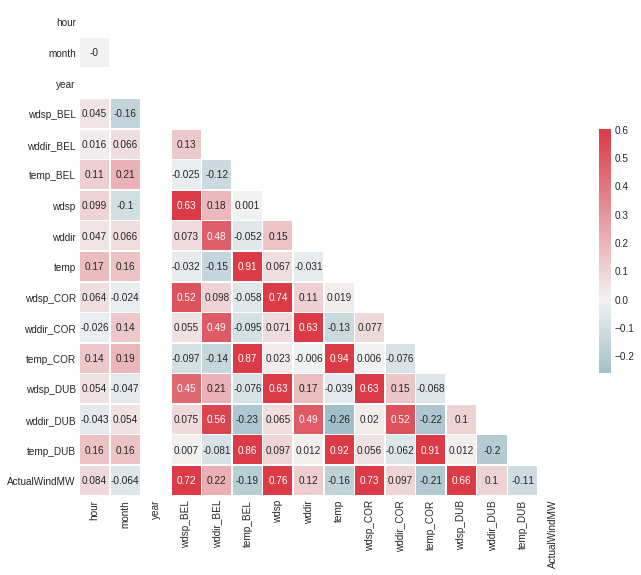

In [59]:
import seaborn as sns

num_df = redds.select_dtypes(['int', 'float'])
# Compute the correlation matrix
corr = num_df.corr()
corr = np.round(corr, 3)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.6, center=0, annot= True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# Split data into Training (day of month between 1st and 21st) and Validation (day of the months above 22nd) sets and run Random Forest 

In [60]:
def setdayatt(row):
    row["day"] = row.date.day
    return row

redds["day"] = 0
redds = redds.apply(setdayatt, axis='columns')



In [61]:
from sklearn.model_selection import train_test_split

# Split train vs. Test for day of the month <> 22 to avoid overfitting
X_train_full = redds.loc[(redds.day > 0) & (redds.day < 22), :]
X_valid_full = redds.loc[(redds.day > 22), :]

y_train = X_train_full.ActualWindMW
X_train_full.drop(['ActualWindMW'], axis=1, inplace=True)

y_valid = X_valid_full.ActualWindMW
X_valid_full.drop(['ActualWindMW'], axis=1, inplace=True)

# Break off validation set from training data
#X_train_full, X_valid_full, y_train, y_valid = train_test_split(redds, y, train_size=0.8, test_size=0.2,random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64', 'bool']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()


In [62]:
y_train.shape , X_train.shape, y_valid.shape, X_valid.shape

((6048,), (6048, 17), (2425,), (2425, 17))

In [63]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))


MAE: 330.36905154639174


In [64]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2425 entries, 26811 to 35067
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hour       2425 non-null   float64
 1   isweekday  2425 non-null   bool   
 2   month      2425 non-null   float64
 3   year       2425 non-null   float64
 4   wdsp_BEL   2425 non-null   int64  
 5   wddir_BEL  2425 non-null   int64  
 6   temp_BEL   2425 non-null   float64
 7   wdsp       2425 non-null   int64  
 8   wddir      2425 non-null   int64  
 9   temp       2425 non-null   float64
 10  wdsp_COR   2425 non-null   int64  
 11  wddir_COR  2425 non-null   int64  
 12  temp_COR   2425 non-null   float64
 13  wdsp_DUB   2425 non-null   int64  
 14  wddir_DUB  2425 non-null   int64  
 15  temp_DUB   2425 non-null   float64
 16  day        2425 non-null   int64  
dtypes: bool(1), float64(7), int64(9)
memory usage: 324.4 KB


In [65]:
# Perform EDA, visualize, etc...
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{"secondary_y": True}]],
    subplot_titles=("Wind"))


fig.add_trace(go.Scatter(x=redds['date'], y=redds['ActualWindMW'],
                    mode='lines',
                    name='Wind Actual',showlegend=True), 1, 1, secondary_y=False)

fig.add_trace(go.Scatter(x=X_valid_full['date'], y=preds,
                    mode='lines',
                    name='Pred',showlegend=True), 1, 1, secondary_y=False)


fig.update_layout(
    title_text="Wind actual (blue) vs. Predictions (red) for days 22nd and above each month",
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        l=100,
        r=20,
        t=110,
    ),
    plot_bgcolor='white',
    width=4000,
    height=500
)
fig.show()

# TODO: Load weather forecast for next 24 H and Test!

# Met Éireann Weather Forecast API
Published by: Met Éireann
 32 
Licensed under: Met Eireann Custom Open Data Licence
https://data.gov.ie/dataset/met-eireann-weather-forecast-api/resource/027da6d5-d819-48d1-9b16-331dba169bd1

In [66]:

from xml.dom.minidom import parse
import xml.dom.minidom


In [67]:
def getWeather(lat, long, name):

    url = "http://metwdb-openaccess.ichec.ie/metno-wdb2ts/locationforecast?lat={};long={}".format(lat, long)
    s = requests.get(url).content

    DOMTree = xml.dom.minidom.parse(io.StringIO(s.decode('utf-8')))

    collection = DOMTree.documentElement
    if collection.hasAttribute("shelf"):
       print ("Root element : ", collection.getAttribute("shelf"))

    # Get all the movies in the collection
    product = collection.getElementsByTagName("product")

    df_cols = ['date', 'wddir', 'wdsp', 'temp']
    rows = []

    product = collection.getElementsByTagName("product")
    timefcs = collection.getElementsByTagName("time")


    # Print detail of each movie.
    for timefc in timefcs:
        if timefc.hasAttribute("from"):
            fromtime =""
            wdeg = None
            wsp = None
            temp = None

            #print ("from: ", timefc.getAttribute("from"))
            fromtime = timefc.getAttribute("from")

            location = timefc.getElementsByTagName('location')[0]

            if (len(location.getElementsByTagName('windDirection')) > 0 ):
                wd = location.getElementsByTagName('windDirection')[0]
                if wd.hasAttribute("deg"):
                    wdeg = float(wd.getAttribute("deg"))
                    #print ("Wi)nd Direction deg: ", wd.getAttribute("deg"))    

            if (len(location.getElementsByTagName('windSpeed')) > 0):
                wsp = location.getElementsByTagName('windSpeed')[0]
                if wsp.hasAttribute("mps"):
                    wsp = float(wsp.getAttribute("mps"))

            if (len(location.getElementsByTagName('temperature')) > 0):
                temp = location.getElementsByTagName('temperature')[0]
                if temp.hasAttribute("value"):
                    temp = float(temp.getAttribute("value"))
        #print ("From: " + fromtime + " Wind Direction deg: " + str(wdeg) + " Wind Speed mps: " + str(wsp))    
        if (wdeg != None):
            rows.append({"date": fromtime, "wddir": wdeg, "wdsp": wsp, "temp": temp})


    # <windDirection id="dd" deg="348.0" name="N"/>
    # <windSpeed id="ff" mps="3.2" beaufort="2" name="Svak vind"/>


    out_df = pd.DataFrame(rows, columns = df_cols)
    
    out_df["date"] = pd.to_datetime(out_df["date"], infer_datetime_format=True, errors='ignore')

    out_df.to_csv(name + "weather.csv")

    return out_df

In [68]:
# Belmullet: 54.225, -9.991
lat=54.225
long=-9.991

BELMULLETds = getWeather(lat, long, "Belmullet")

In [70]:
# Cork Airport: 51.8382 Longitude: -8.4880
lat= 51.8382
long= -8.4880

corkairportds = getWeather(lat, long, "Cork")

In [71]:
# Shannon Airport, Ireland. Latitude: 52.7012 Longitude: -8.9215.
lat= 52.7012
long= -8.9215

shannonairportds = getWeather(lat, long, "Shannon")

In [72]:
# Dublin Airport in Ireland. Latitude: 53.4264 Longitude: -6.2499
lat= 53.4264
long= -6.2499

dublinairportds = getWeather(lat, long, "Dublin")

In [73]:
left = BELMULLETds.set_index(['date']).copy()
right = dublinairportds.set_index(['date'])
#right.index = right.index.tz_convert(None)

wfds = left.join(right, lsuffix="_BEL", rsuffix="_DUB")

right = shannonairportds.set_index(['date'])
wfds = wfds.join(right, lsuffix="", rsuffix="_SHA")

right = corkairportds.set_index(['date'])
wfds = wfds.join(right, lsuffix="", rsuffix="_COR")
wfds = wfds.reset_index()


In [75]:
# Perform EDA, visualize, etc...
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{"secondary_y": True}]],
    subplot_titles=("Met Station"))


fig.add_trace(go.Scatter(x=wfds['date'], y=wfds['wdsp_BEL'],
                    mode='lines',
                    name='Belmullet Wind Speed',showlegend=True), 1, 1, secondary_y=False)

fig.add_trace(go.Scatter(x=wfds['date'], y=wfds['wdsp_COR'],
                    mode='lines',
                    name='Cork Airport Wind Speed',showlegend=True), 1, 1, secondary_y=False)

fig.add_trace(go.Scatter(x=wfds['date'], y=wfds['wdsp'],
                    mode='lines',
                    name='Shannon Airport Wind Speed',showlegend=True), 1, 1, secondary_y=False)
fig.add_trace(go.Scatter(x=wfds['date'], y=wfds['wdsp_DUB'],
                    mode='lines',
                    name='Dublin Airport Wind Speed',showlegend=True), 1, 1, secondary_y=False)


fig.update_layout(
    title_text="Wind speed ",
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        l=100,
        r=20,
        t=110,
    ),
    plot_bgcolor='white',
    width=1400,
    height=500
)
fig.show()

In [76]:
# Weather Hourly data wind speed in knt, for some reason, 1 knt = 0.514 m/s
knot = 0.514
wfds.wdsp_BEL = wfds.wdsp_BEL / knot
wfds.wdsp = wfds.wdsp / knot
wfds.wdsp_COR = wfds.wdsp_COR / knot
wfds.wdsp_DUB = wfds.wdsp_DUB / knot


In [100]:
fig = go.Figure()
fig.add_trace(go.Box(y=newdf['wdsp_BEL'], name='BEL'))
fig.add_trace(go.Box(y=wfds['wdsp_BEL'], name='BEL forecast'))
fig.add_trace(go.Box(y=newdf['wdsp_DUB'], name = 'DUB'))
fig.add_trace(go.Box(y=wfds['wdsp_DUB'], name='DUB forecast'))
fig.add_trace(go.Box(y=newdf['wdsp'], name = 'SHA'))
fig.add_trace(go.Box(y=wfds['wdsp'], name='SHA forecast'))

fig.add_trace(go.Box(y=newdf['wdsp_COR'], name = 'CORK'))
fig.add_trace(go.Box(y=wfds['wdsp_COR'], name='CORK forecast'))
fig.show()

# Run predictions

In [77]:
wfds

date  wddir_BEL   wdsp_BEL  ...  wddir_COR   wdsp_COR  temp_COR
0   2021-03-02 13:00:00      187.1   3.112840  ...       82.5  11.284047       9.1
1   2021-03-02 14:00:00      195.2   2.529183  ...       79.8  10.700389       9.1
2   2021-03-02 15:00:00      238.4   1.556420  ...       84.6  10.505837       8.6
3   2021-03-02 16:00:00        2.2   3.891051  ...       78.2   9.922179       7.3
4   2021-03-02 17:00:00       13.4   3.696498  ...       68.4   9.533074       6.6
..                  ...        ...        ...  ...        ...        ...       ...
107 2021-03-11 00:00:00       86.6  10.894942  ...      243.3  14.007782       9.7
108 2021-03-11 06:00:00        1.6   3.891051  ...      326.9   7.976654       3.7
109 2021-03-11 12:00:00      285.9  15.175097  ...      301.0  12.645914       9.3
110 2021-03-11 18:00:00      272.6  19.649805  ...      278.7  10.505837       6.8
111 2021-03-12 00:00:00      281.0  18.482490  ...      275.2  11.284047       5.0

[112 rows x 13 columns]

In [78]:
wfds["hour"] = 0
wfds["isweekday"] = False
wfds["month"] = 0
wfds['year'] = 0
wfds["day"] = 0
def settimeattfull(row):
    row["hour"] = row.date.hour
    row["isweekday"] = (row.date.isoweekday() < 6) 
    row["month"] = row.date.month
    row["year"] = row.date.year
    row["day"] = row.date.day
    return row

wfds = wfds.apply(settimeattfull, axis='columns')

In [86]:
wfds.columns

Index(['date', 'wddir_BEL', 'wdsp_BEL', 'temp_BEL', 'wddir_DUB', 'wdsp_DUB',
       'temp_DUB', 'wddir', 'wdsp', 'temp', 'wddir_COR', 'wdsp_COR',
       'temp_COR', 'hour', 'isweekday', 'month', 'year', 'day'],
      dtype='object')

In [91]:
redtds = wfds.loc[:, ['hour', 'isweekday', 'month', 'year',
                      'wdsp_BEL', 'wddir_BEL', 'temp_BEL',
                      'wdsp', 'wddir', 'temp',
                      'wdsp_COR', 'wddir_COR',  'temp_COR',
                      'wdsp_DUB', 'wddir_DUB',  'temp_DUB', 'day']]

In [92]:
redtds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hour       112 non-null    int64  
 1   isweekday  112 non-null    bool   
 2   month      112 non-null    int64  
 3   year       112 non-null    int64  
 4   wdsp_BEL   112 non-null    float64
 5   wddir_BEL  112 non-null    float64
 6   temp_BEL   112 non-null    float64
 7   wdsp       112 non-null    float64
 8   wddir      112 non-null    float64
 9   temp       112 non-null    float64
 10  wdsp_COR   112 non-null    float64
 11  wddir_COR  112 non-null    float64
 12  temp_COR   112 non-null    float64
 13  wdsp_DUB   112 non-null    float64
 14  wddir_DUB  112 non-null    float64
 15  temp_DUB   112 non-null    float64
 16  day        112 non-null    int64  
dtypes: bool(1), float64(12), int64(4)
memory usage: 14.2 KB


In [90]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2425 entries, 26811 to 35067
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hour       2425 non-null   float64
 1   isweekday  2425 non-null   bool   
 2   month      2425 non-null   float64
 3   year       2425 non-null   float64
 4   wdsp_BEL   2425 non-null   int64  
 5   wddir_BEL  2425 non-null   int64  
 6   temp_BEL   2425 non-null   float64
 7   wdsp       2425 non-null   int64  
 8   wddir      2425 non-null   int64  
 9   temp       2425 non-null   float64
 10  wdsp_COR   2425 non-null   int64  
 11  wddir_COR  2425 non-null   int64  
 12  temp_COR   2425 non-null   float64
 13  wdsp_DUB   2425 non-null   int64  
 14  wddir_DUB  2425 non-null   int64  
 15  temp_DUB   2425 non-null   float64
 16  day        2425 non-null   int64  
dtypes: bool(1), float64(7), int64(9)
memory usage: 324.4 KB


In [94]:

# Preprocessing of validation data, get predictions
preds = clf.predict(redtds)

In [95]:
preds

array([ 973.97,  802.38,  800.84,  561.27,  568.86,  636.5 ,  685.62,
        748.89,  486.21,  476.18,  488.17,  565.99,  546.38,  657.88,
        543.87,  561.64,  526.71,  337.26,  557.41,  519.22,  671.95,
        890.37,  600.23,  554.37,  552.33,  507.15,  977.52,  808.92,
        690.16,  673.99,  688.04,  484.08,  391.54,  296.59,  473.39,
        338.17,  317.76,  307.54,  280.09,  275.31,  444.88,  319.1 ,
        318.67,  338.11,  598.28,  276.42,  365.21,  464.24,  696.63,
        630.08,  658.61,  684.35,  762.09,  650.5 ,  743.31, 1014.43,
       1038.98,  995.84,  923.37,  779.28,  896.12,  892.44,  818.34,
        750.59,  846.69,  938.22, 1138.26, 1450.88, 1640.7 , 1414.33,
       1908.69, 1847.62, 1635.59, 1514.45, 1379.05, 1408.94, 1288.79,
       1340.33, 1321.53, 1380.65, 1458.97, 1762.62, 1846.  , 1830.3 ,
       2277.06, 1252.58, 1507.05, 1388.06, 1264.12,  952.31, 1205.52,
       1350.84, 1583.58,  669.9 ,  638.47, 1009.48, 1361.28, 2300.51,
       2910.62, 2021

In [99]:
# Perform EDA, visualize, etc...
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{"secondary_y": True}]],
    subplot_titles=("Met Station"))


fig.add_trace(go.Scatter(x=wfds['date'], y=wfds['wdsp_BEL'],
                    mode='lines',
                    name='Belmullet Wind Speed',showlegend=True), 1, 1, secondary_y=False)

fig.add_trace(go.Scatter(x=wfds['date'], y=preds,
                    mode='lines',
                    name='Wind Preds',showlegend=True), 1, 1, secondary_y=True)

fig.update_layout(
    title_text="Wind speed ",
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        l=100,
        r=20,
        t=110,
    ),
    plot_bgcolor='white',
    width=1400,
    height=500
)
fig.show()